In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Buffer Generator

In [2]:
def buildStableSignal(fisrtSignal, pri, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        count += 1
        newPulse = fisrtSignal + count * pri
                
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    info = (fisrtSignal, pri, deviationBuffer.std())
    
    deviationBuffer = [round(num) for num in deviationBuffer]
    buffer = np.add(buffer, deviationBuffer).tolist()
        
    return buffer, info

In [3]:
# Use case 
# stableSignalBuffer, info = buildStableSignal(15, 30)

In [4]:
def buildStaggerSignal(fisrtSignal, pris, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        newPulse += pris[count%len(pris)]
        count += 1
        
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    info = (fisrtSignal, pris, deviationBuffer.std())
    
    deviationBuffer = [round(num) for num in deviationBuffer]
        
    return np.add(buffer, deviationBuffer).tolist(), info

In [5]:
# Use case 
# staggerSignalBuffer, info = buildStaggerSignal(15, [30, 80])

In [6]:
def buildJitterSignal(fisrtSignal, pri, jitter, variance = 1, thresholdBuffer = 10000):
    buffer = list()
    newPulse = fisrtSignal
    count = 0
    
    while newPulse < thresholdBuffer:
        buffer.append(newPulse)
        count += 1
        newPulse = fisrtSignal + count * pri
                
    deviationBuffer = np.random.normal(0, 1, len(buffer)) * variance
    deviationBuffer[0] = 0
    
    jitterBuffer = np.random.uniform(-1, 1, len(buffer)) * (jitter/100) * pri
    jitterBuffer[0] = 0
    deviationAndJitterBuffer = np.add(deviationBuffer, jitterBuffer)
    
    info = (fisrtSignal, pri, deviationAndJitterBuffer.std())
    
    deviationAndJitterBuffer = [round(num) for num in deviationAndJitterBuffer]
    buffer = np.add(buffer, deviationAndJitterBuffer).tolist()
        
    return buffer, info

In [7]:
# Use case 
# jitterSignalBuffer, info = buildJitterSignal(50, 100, 8)

In [8]:
def buildBuffer(stables, staggers, jitters):
    buffer = list()
    info = dict()
    
    info['stable'] = list()
    info['stagger'] = list()
    info['jitter'] = list()
    
    for stable in stables:
        tempBuffer, tempInfo = buildStableSignal(stable[0], stable[1], stable[2], stable[3]) ####
        buffer.extend(tempBuffer)
        info['stable'].append(tempInfo)
        
        
    for stagger in staggers:
        tempBuffer, tempInfo = buildStaggerSignal(stagger[0], stagger[1], stagger[2], stagger[3]) ####
        buffer.extend(tempBuffer)
        info['stagger'].append(tempInfo)
    
    for jitter in jitters:
        tempBuffer, tempInfo = buildJitterSignal(jitter[0], jitter[1], jitter[2], jitter[3], jitter[4]) ####
        buffer.extend(tempBuffer)
        info['jitter'].append(tempInfo)
    
    
    buffer.sort()
    
    return buffer, info

In [9]:
def plot_grafico(valores, barras_vermelhas=[], title='Buffer'):
    if isinstance(title, int):
        title = f" PRI: {title}"
    
    plt.figure(figsize=(15, 2))
    
    # Definindo as cores de cada barra
    cores = ['red' if val in barras_vermelhas else 'blue' for val in valores]
    
    altura_fixa = 5
    plt.bar(valores, [altura_fixa] * len(valores), width=10, align='center', color=cores)
    
    plt.xticks(valores, rotation=90, fontsize=13)
    plt.ylim(0, 10)
    plt.yticks([])
    plt.grid(False)
    plt.tight_layout()
    plt.title(title, fontsize=13)
    plt.show()
    plt.close()

# Solver

## PRIL

In [115]:
stableWindowWidth = 4

In [116]:
pd.read_excel("T_PRIL.xlsx", names=['lower bound', 'upper bound', 'window'])

,lower bound,upper bound,window
0,10,18,2
1,20,36,2
2,20,36,4
3,38,70,2
4,38,70,8
5,72,136,3
6,72,136,16
7,139,267,3
8,139,267,32
9,269,525,3


In [117]:
def findPPIs(buffer, pathToPrilFile='T_PRIL.xlsx'):
    
    ppis = list()
    
    PRIL = pd.read_excel(pathToPrilFile, names=['lower bound', 'upper bound', 'window'])    

    for index, row in PRIL.iterrows():
        lowerBoundWindow = row['lower bound']
        upperBoundWindow = row['upper bound']
        windowWidth = row['window']

        for i in range(len(buffer)):
            for j in range(len(buffer)):
                if i >= j:
                    continue

                ppi = buffer[j] - buffer[i]

                if ppi > upperBoundWindow + windowWidth:
                    break


                if (ppi >= lowerBoundWindow + windowWidth) and (ppi< upperBoundWindow + windowWidth):
                    ppis.append((i, j, windowWidth, ppi, (lowerBoundWindow, upperBoundWindow)))
                    
    ppis = sorted(ppis, key=lambda ppiRecord: ppiRecord[3])
                    
    return ppis

In [118]:
def dropRepeatTuple(tuplas):
    observed = set()
    result = []

    for tupla in tuplas:
        key = (tupla[0], tupla[1])
        if key not in observed:
            observed.add(key)
            result.append(tupla)
    
    return result

In [119]:
def findPRIs(PPIs):
    
    PRIs = dict()
    candidatesPRIList = list()

    for index in range(len(PPIs)-1):

        if len(candidatesPRIList) == 0:
            candidatesPRIList.append(PPIs[index])
            
            
        _sumPPIs = sum([candidatePRIList[3] for candidatePRIList in candidatesPRIList])
        meanPPI = _sumPPIs/len(candidatesPRIList)
        diffPPI = abs(meanPPI - PPIs[index+1][3])
        
        if diffPPI <= stableWindowWidth:
#         if diffPPI <= PPIs[index][2]: # windowWidth
            candidatesPRIList.append(PPIs[index+1])

        else:
            candidatesPRIList = dropRepeatTuple(candidatesPRIList)
            candidatesPRIList = sorted(candidatesPRIList, key=lambda priRecord: priRecord[0])
            PRIs[round(meanPPI)] = candidatesPRIList.copy()
            candidatesPRIList = list() 

    candidatesPRIList = dropRepeatTuple(candidatesPRIList)
    candidatesPRIList = sorted(candidatesPRIList, key=lambda priRecord: priRecord[0])
    PRIs[round(meanPPI)] = candidatesPRIList.copy()
    
    PRIs = {key: value for key, value in PRIs.items() if len(value) >= 4}
    
    return PRIs

In [120]:
def findLargestSequence(tuplas, atual=None):
    if atual is None:
        atual = []

    if not any(t for t in tuplas if (not atual or t[0] == atual[-1][1])):
        return atual

    sequencias = [atual]

    for t in tuplas:
        if not atual or t[0] == atual[-1][1]:
            nova_sequencia = findLargestSequence(tuplas, atual + [t])
            if len(nova_sequencia) > len(sequencias[0]):
                sequencias[0] = nova_sequencia

    return sequencias[0]

In [148]:
def multipleFilterPRI(PRIs):
                
    keysOrdenated = sorted(PRIs.keys())
    keysToRemove = set()
    result = dict()
    
    for index, key in enumerate(keysOrdenated):
        for j in range(index):
            smallerKey = keysOrdenated[j]
            if key % smallerKey < stableWindowWidth:
                keysToRemove.add(key)
                break

    for key in keysToRemove:
        del PRIs[key]
        

    for key, tuplas in PRIs.items():
        result[key] = findLargestSequence(tuplas).copy()

    result = {key: value for key, value in result.items() if len(value) >= 4}

    return result

In [149]:
def printPRIs(buffer, PRIs, quantSignal = 30):
    for key, tuplas in PRIs.items():
        
        selectedSignalsTuple = set()
        
        for tupla in tuplas:
            selectedSignalsTuple.add(buffer[tupla[0]])
            selectedSignalsTuple.add(buffer[tupla[1]])
            
        signals = list(selectedSignalsTuple)
        plot_grafico(buffer[:quantSignal], signals, key)    

# Use Case

## Buffer

In [150]:
stables = [[15, 130, 1, 2000], [60, 80, 1, 2000]] # [[15, 50, 1, 10000], [25, 75, 1, 10000]] # [[fisrtSignal, pri, variance = 1, thresholdBuffer = 10000]]
staggers = [] # [[fisrtSignal, pris, variance = 1, thresholdBuffer = 10000]]
jitters = [] # = [[], []]  # [[fisrtSignal, pri, jitter, variance = 1, thresholdBuffer = 10000]]

In [151]:
buffer, info = buildBuffer(stables, staggers, jitters)

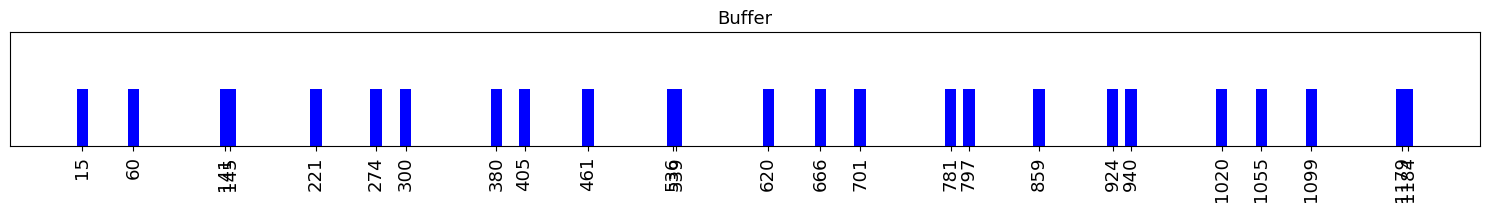

In [152]:
plot_grafico(buffer[:25], [])

In [153]:
PPIs = findPPIs(buffer)

In [154]:
candidatePRIs = findPRIs(PPIs)

In [155]:
PRIs = multipleFilterPRI(candidatePRIs)

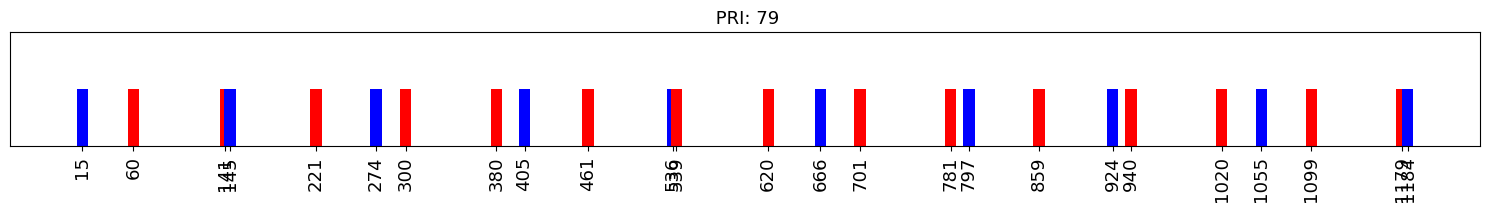

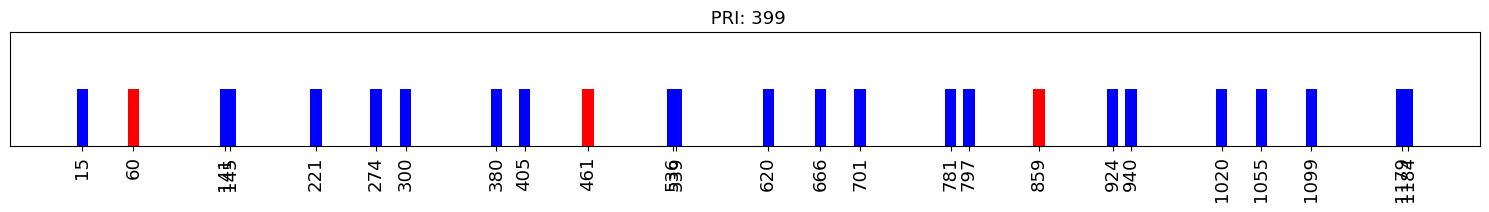

In [158]:
printPRIs(buffer, PRIs, 25)